# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stencil_calculator as sc
import numerical_derivative as nd
%matplotlib inline

Here, I will show some examples on how you can use the findiff package to take numerical derivatives of functions.

# 1st example - Toy model

For the first example, let's take derivatives of the following function:

$$
f(x,a,b)=\sin(x\,a)\cos(x\,b)\;,
$$

with respect to $a$ and $b$.

In [2]:
x_array = np.arange(-10,10,0.01)
def function_test(theta,kwargs):
    return np.sin(kwargs["x_array"]*theta[0]) * np.cos(kwargs["x_array"]*theta[1])

We can inizialize the FiniteDerivative method in the following way:

In [3]:
ND_obj = nd.FiniteDerivative()

In [4]:
N_taylor = 4 #The code will compute derivatives up to this order
N_grid = 6 #The size of the stencil will be 2*N_grid + 1

#These are the specifications for the grid. The first value is the reference one, and the second is the step
#size in units of the reference values. 

# Example: If "x":[x0, x_percentage], the grid spacing will be x0*x_percentage

expansion_table = {
    "a":[-1, 0.1],
    "b":[1, 0.1]
}

ND_obj.define_setup(N_taylor,N_grid, expansion_table)

Now, we compute the function in the total grid defined above

In [5]:
ND_obj.evaluate_in_grid(function_test,x_array=x_array)

100%|██████████| 169/169 [00:00<00:00, 20475.39it/s]


Now, to take the derivatives:

In [6]:
ND_obj.take_derivative_ALL(verbose=False)

And thats it! Lets plot the results:

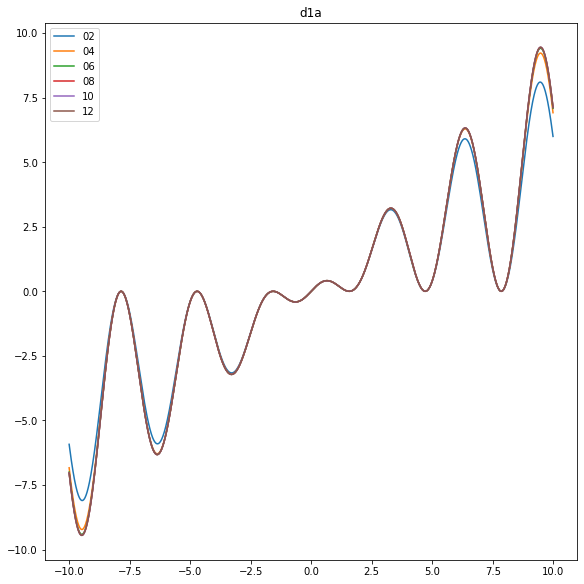

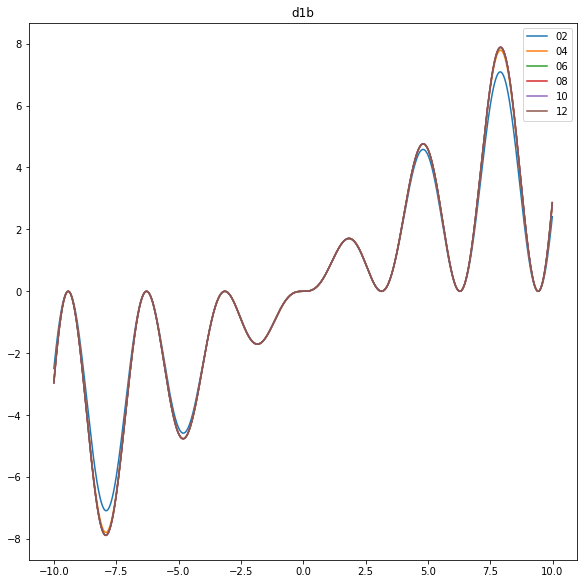

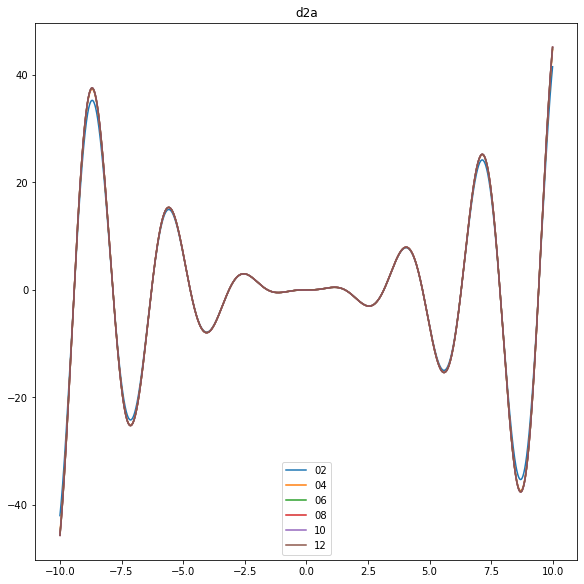

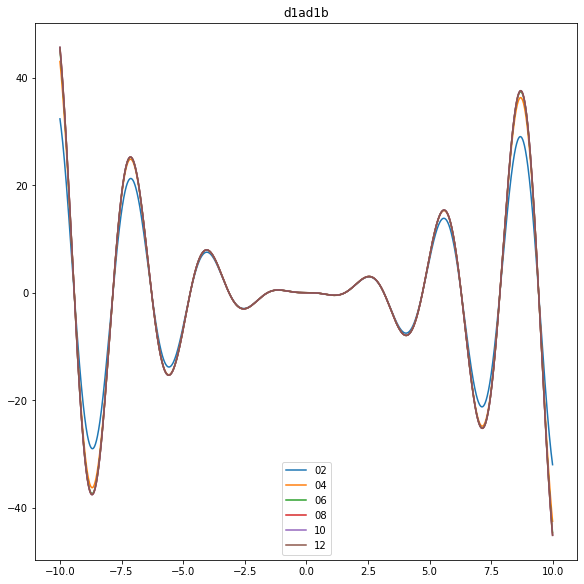

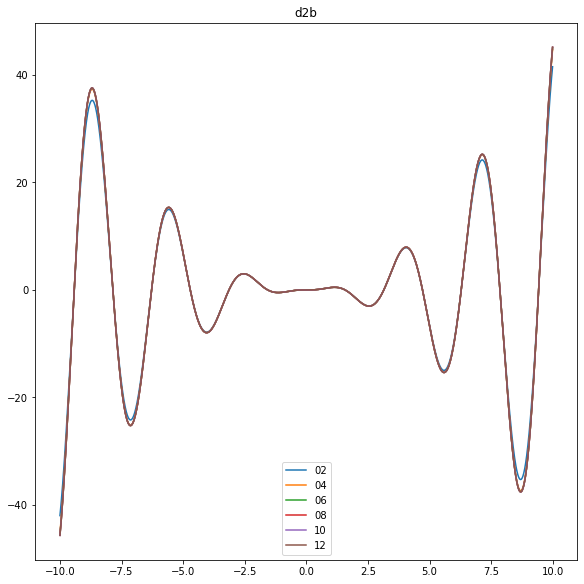

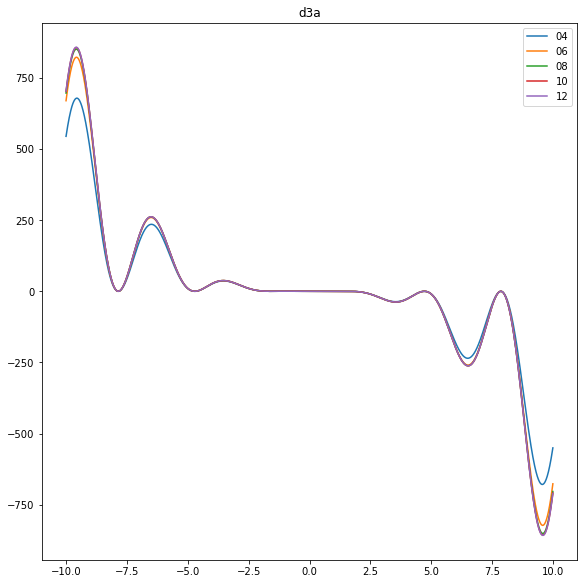

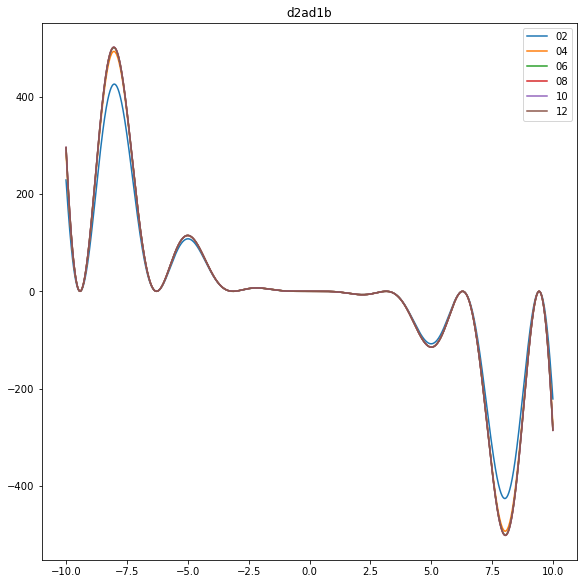

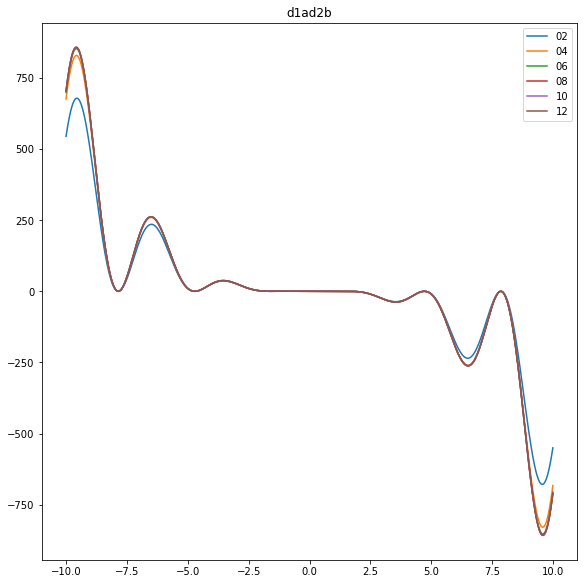

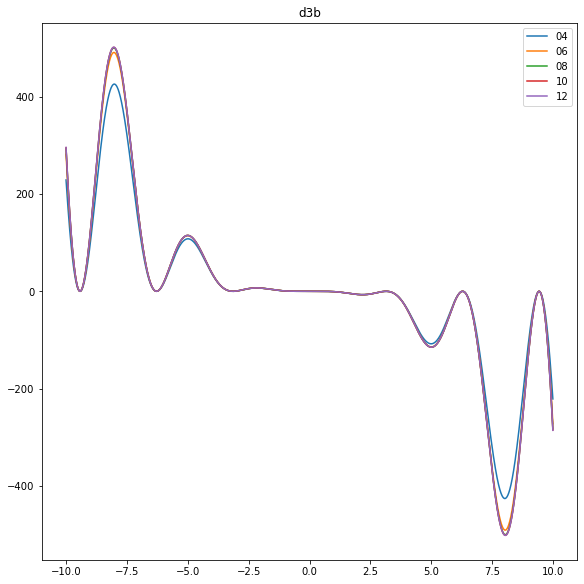

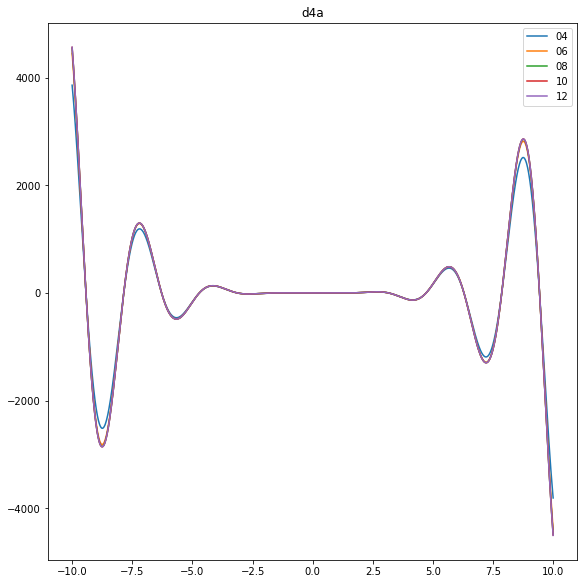

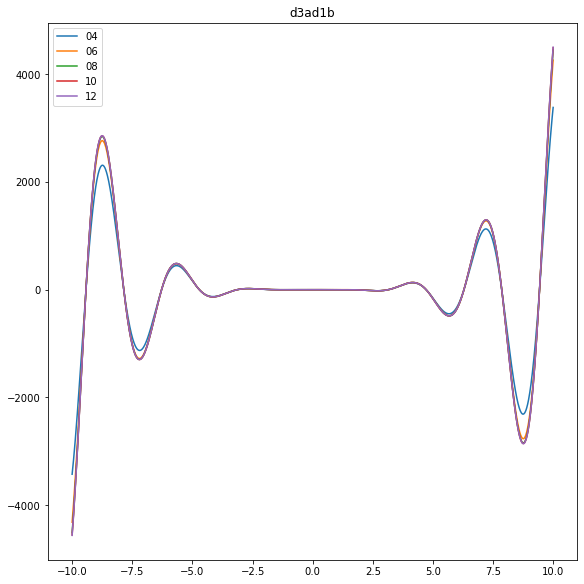

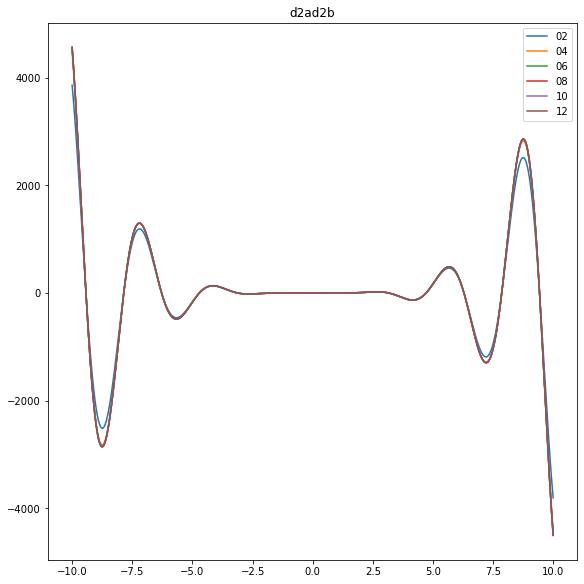

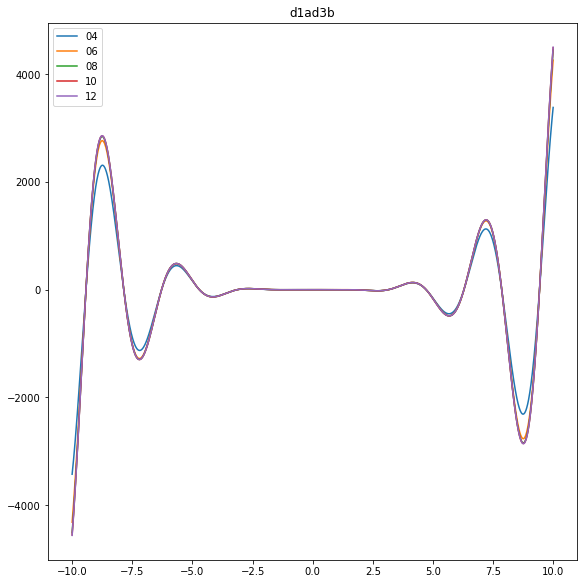

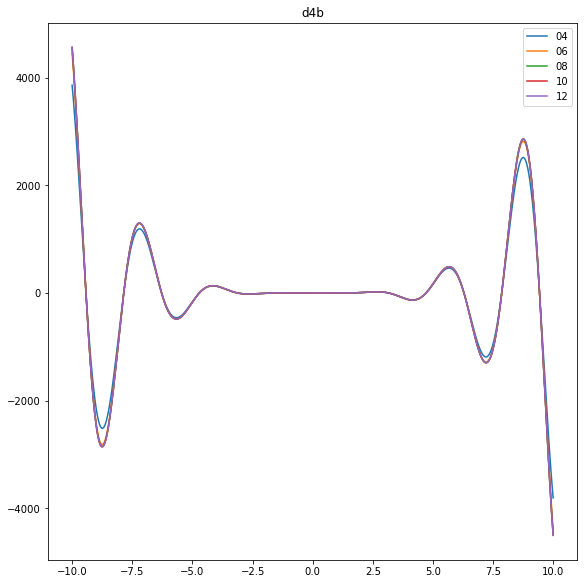

In [7]:
for this_derivative in list(ND_obj.derivatives.keys()):
    plt.figure(figsize = (8,8), constrained_layout = True)
    plt.title(this_derivative)
    for this_stencil in list(ND_obj.derivatives[this_derivative]):
        try:
            plt.plot(x_array, ND_obj.derivatives[this_derivative][this_stencil], label = this_stencil)
        except:
            pass
    plt.legend()
    plt.show()

The code will use all stencil sizes to compute all derivatives. The stencil size usually controls the precision of the derivative: a larger stencil size will lead to a more accurate derivative. The output is a dictionary with all the derivatives:

In [8]:
list(ND_obj.derivatives.keys())

['d1a',
 'd1b',
 'd2a',
 'd1ad1b',
 'd2b',
 'd3a',
 'd2ad1b',
 'd1ad2b',
 'd3b',
 'd4a',
 'd3ad1b',
 'd2ad2b',
 'd1ad3b',
 'd4b']

Each of of these entries leads to another dictionary

In [9]:
list(ND_obj.derivatives['d1a'].keys())

['02', '04', '06', '08', '10', '12']

Those inner dictionaries represent the precision (or stencil size) used to compute the derivative associated with the first key.

# 2nd example - Cosmology: linear matter power spectrum

I will use the example in the CLASS-PT website to get the linear matter power-spectrum, which is obtained by solving some complicated equations numerically.

In [10]:
from classy import Class

In [11]:
cosmological_parameters = {"A_s": 2.6085e-09,
                            "n_s": 0.9611,
                            "tau_reio": 0.0952,
                            "omega_b": 0.02216104779708,
                            "omega_cdm": 0.11888851928939997,
                            "h": 0.6777,
                            "YHe": 0.2425,
                            "N_ur": 2.0328,
                            "N_ncdm": 1,
                            "m_ncdm": 0.06,
                            "z_pk": 0.02,
                            "output": "mPk",
                            "non linear": "PT",
                            "IR resummation": "Yes",
                            "Bias tracers": "Yes",
                            "cb": "No",
                            "RSD": "Yes",
                            "AP": "No"}


M = Class()
M.set(cosmological_parameters)
#let's first take a look at the one-loop power spectrum for matter without IR resummation
M.compute()

h = M.h()
kvec = np.logspace(-2,np.log10(3),1000) # array of kvec in h/Mpc
khvec = kvec*h # array of kvec in 1/Mpc

M.initialize_output(khvec, 0.02, len(khvec))
operators = M.get_pk_mult(khvec, 0.02, len(khvec))*h**3

Text(0, 0.5, '$k\\times P(k)$ [Mpc/$h$]$^2$')

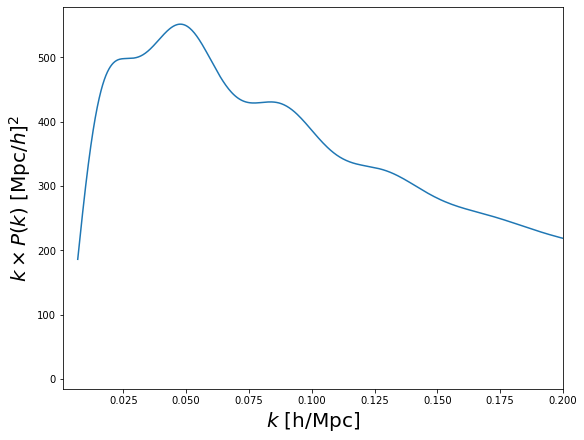

In [12]:
plt.figure(figsize = (8,6), constrained_layout= True)
plt.plot(khvec, khvec*operators[14])
plt.xlim((0.001,0.2))
plt.xlabel(r"$k$ [h/Mpc]", size = 20)
plt.ylabel(r"$k\times P(k)$ [Mpc/$h$]$^2$", size = 20)

Now, let's see how we can compute the derivative of the linear matter power spectrum with respect to $\omega_{\rm cdm}$

In [13]:
#We first define a function that updates omega_cdm and return the new P(k)
def ComputePk_h(x):
    cosmological_parameters["omega_cdm"] = x[0]
    M = Class()
    M.set(cosmological_parameters)
    #let's first take a look at the one-loop power spectrum for matter without IR resummation
    M.compute()
    M.initialize_output(khvec, 0.02, len(khvec))
    operators = M.get_pk_mult(khvec, 0.02, len(khvec))*h**3
    return operators[14]

In [14]:
ND_obj = nd.FiniteDerivative()

N_taylor = 3 #The code will compute derivatives up to this order
N_grid = 4 #The size of the stencil will be 2*N_grid + 1

expansion_table = {
    "omega_cdm":[0.1190, 0.1]
}

ND_obj.define_setup(N_taylor,N_grid, expansion_table)

In [15]:
ND_obj.evaluate_in_grid(ComputePk_h)

100%|██████████| 9/9 [01:12<00:00,  8.05s/it]


In [16]:
ND_obj.take_derivative_ALL()

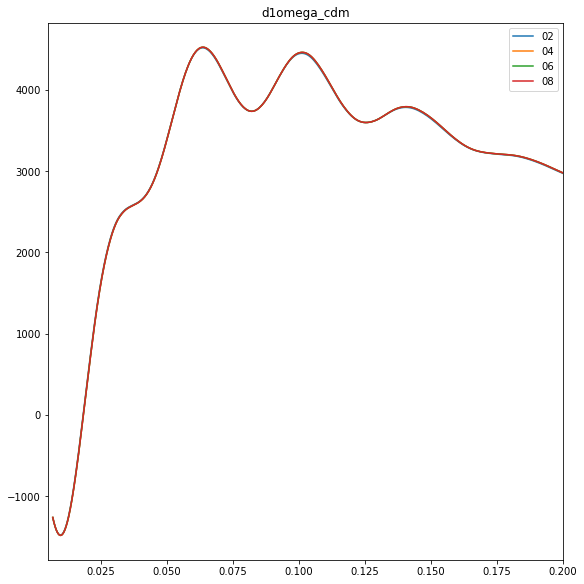

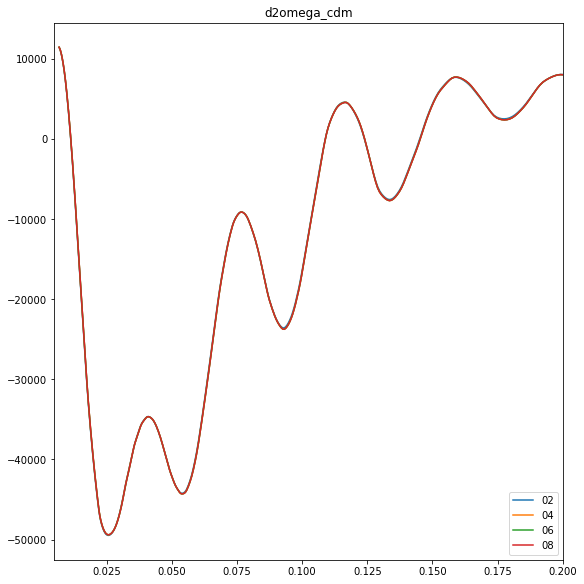

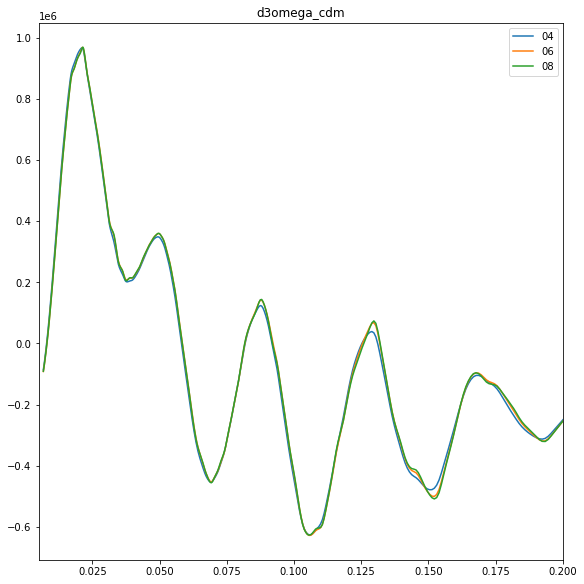

In [17]:
for this_derivative in list(ND_obj.derivatives.keys()):
    plt.figure(figsize = (8,8), constrained_layout = True)
    plt.title(this_derivative)
    for this_stencil in list(ND_obj.derivatives[this_derivative]):
        try:
            plt.plot(khvec, khvec*ND_obj.derivatives[this_derivative][this_stencil], label = this_stencil)
            plt.xlim((0.005,0.2))
        except:
            pass
    plt.legend()
    plt.show()